# `jax` and `jit` practise notebook

In [2]:
#@title Imports & Utils
# Imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax

## Setting up the problem with preliminary tests

### Hard-core repulsive potential

$V(x) = \begin{cases} 
      \exp(-x/\epsilon) & x\leq 0.2 \\
      0 & x>0.2
   \end{cases}$

In [2]:
def hardCore(x):
  eps = 1e-2
  return jnp.where(x<=0.2, 1/jnp.exp(x/eps), 0)

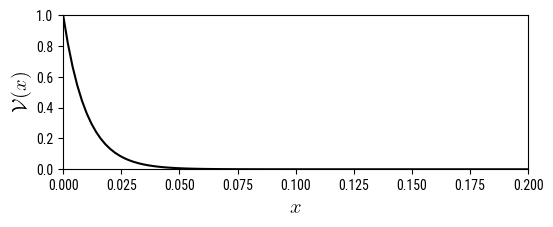

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Roboto Condensed")
plt.rc("xtick", labelsize="medium")

hCdx = jax.grad(hardCore)
hCdxVec = jax.vmap(hCdx)

xmax = 0.2
x = jnp.linspace(0,xmax,100)

fig = plt.figure(figsize=(6, 2), dpi=100)
ax = plt.subplot(xlim=[0, 0.20], ylim=[0, 1])
plt.rcParams.update({"text.usetex": True})

ax.plot(x, hardCore(x), c='k')
# ax.plot(x, hCdxVec(x))
ax.set_xlabel(r'$x$',usetex=True, fontsize=15)
ax.set_ylabel(r'$\mathcal{V}(x)$',usetex=True,rotation=90, fontsize=15)

plt.show()

### Gaussian white noise statistics

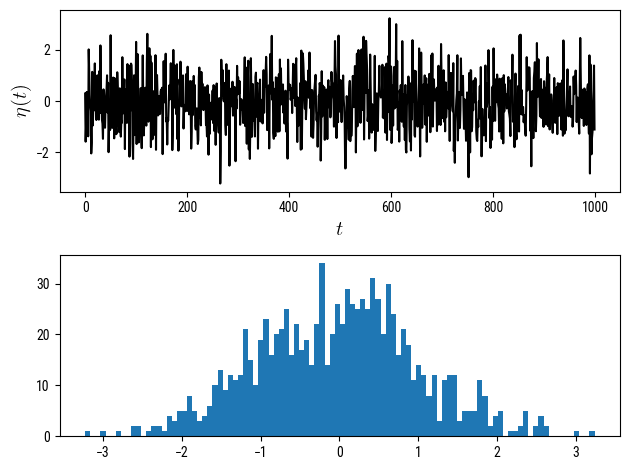

In [41]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Roboto Condensed")
plt.rc("xtick", labelsize="medium")

key = random.PRNGKey(42)
nmax = 1000
xLst = random.normal(key, shape=(nmax,))

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(xLst, c='k')
ax1.set_xlabel(r'$t$',usetex=True, fontsize=15)
ax1.set_ylabel(r'$\eta(t)$',usetex=True,rotation=90, fontsize=15)

ax2.hist(xLst, bins=100)

plt.tight_layout()
plt.show()

### Dynamics of an active brownian particle given by the Langevin equation:

$ \dot{\mathbf{r}}(t) = v_o \hat{\mathbf{n}}$

$ \dot{\theta}(t) = \sqrt{2D} \eta(t)$

where $\hat{\mathbf{n}} = (\cos \theta, \sin \theta)$ and $\langle \eta(t) \eta(t') = \delta(t-t') \rangle$.

In [59]:
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nMax = 1000
        self.dt = 1e-3
        self.diff = 1e-2
        self.vo = 0.5

class agent():
    def __init__(self) -> None:
        super().__init__()
        self.rx = 0.
        self.ry = 0.
        self.thet = 0.
        self.iStep = 0
        self.rxFull = self.rx
        self.ryFull = self.ry
        self.thetFull = self.thet

In [153]:
def rand_von_Mises(N,mu,kappa):

    """
        rand_von_Mises(N,mu,kappa)
        ==========================

        Generates theta an Nx1 array of samples of a von Mises distribution
        with mean direction mu and concentration kappa.

        INPUT:

            * N - number of samples to be generated (integer)
            * mu - mean direction (float)
            * kappa - concentration (float)

        OUTPUT:

            * theta - an Nx1 array of samples of a von Mises distribution with mean
            direction mu and concentration kappa.

         References:
         ===========

         Algorithm first given in

         [1] D. J. Best and N. I. Fisher, Efficient Simulation of the von Mises
         Distribution, Applied Statistics, 28, 2, 152--157, (1979).

         Also given in the following textbook/monograph

         [2] N. I. Fisher, Statistical analysis of circular data, Cambridge University Press, (1993).

    """

    # Checks
    # =======

    # N should be a positive non-zero integer scalar
    if (type(N) is not int):
        raise TypeError("N must be a positive non-zero integer.")
    if N <= 0:
        raise Exception("N must be a positive non-zero integer.")

    #  mu should be a real scalar. It can wrap around the circle, so it can be negative, positive and also
    #  outside the range [0,2*pi].
    if (type(mu) is not float) and (type(mu) is not int):
        raise TypeError("mu must be a real scalar number.")

    # kappa should be positive real scalar
    if (type(kappa) is not float) and (type(kappa) is not int):
        raise TypeError("kappa must be a positive float.")
    if kappa < 0:
        raise Exception("kappa must be a positive float.")

    #  SPECIAL CASE
    # ==============

    #  As kappa -> 0 one obtains the uniform distribution on the circle
    float_epsilon = np.finfo(float).eps
    if kappa <= float_epsilon:
        theta = 2.0 * np.pi * np.random.rand(N,1) # [0,1] -> [0,2*pi]
        return theta

    # MAIN BODY OF ALGORITHM
    # =======================

    # Used same notation as Ref.~[2], p49

    a = 1.0 + np.sqrt(1.0 + 4.0 * kappa**2)
    b = (a - np.sqrt(2.0 * a)) / (2.0 * kappa)
    r = (1.0 + b**2) / (2.0 * b)

    counter = 0
    theta = np.zeros((N,1))

    while counter <= N-1:

        # Pseudo-random numbers sampled from a uniform distribution [0,1]
        U1 = np.random.rand()
        U2 = np.random.rand()
        U3 = np.random.rand()

        z = np.cos(np.pi * U1)
        f = (1.0 + r *z) / (r + z)
        c = kappa * (r - f)

        if ( ((c * (2.0 - c) - U2) > 0.0)  or ((np.log(c/U2) + 1.0 - c) > 0.0) ):

            theta[counter] = np.mod(np.sign(U3 - 0.5) * np.arccos(f) + mu, 2*np.pi)     
            counter += 1

    return theta

In [60]:
# @jit
def propgtr(p, agt, randF) -> None:
    agt.rx += p.vo*p.dt*jnp.cos(agt.thet)
    agt.ry += p.vo*p.dt*jnp.sin(agt.thet)
    agt.thet += jnp.sqrt(p.diff*p.dt)*randF
    agt.rxFull = np.vstack([agt.rxFull, agt.rx])
    agt.ryFull = np.vstack([agt.ryFull, agt.ry])
    agt.thetFull = np.vstack([agt.thetFull, agt.thet])
    # return agt

def normVec(x, y):
    return jnp.sqrt(x**2 + x**2)

In [61]:
p = params()
ag = agent()
# key = random.PRNGKey(42)
# subkeys = random.split(key, p.nMax)
randF = rand_von_Mises(p.nMax,0,8)
nVec = jax.vmap(normVec)

for ind in jnp.arange(p.nMax):
    propgtr(p, ag, randF[ind])

NameError: name 'rand_von_Mises' is not defined

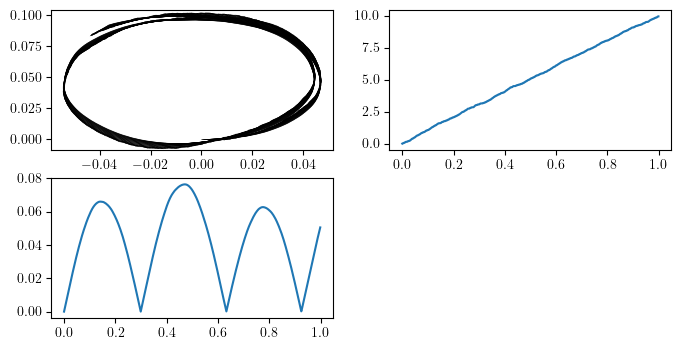

In [157]:
dpi = 100
figsize = (8, 4)

fig = plt.figure(figsize=figsize, dpi=dpi)
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
t = jnp.arange(p.nMax)*p.dt

ax1.quiver(ag.rxFull, ag.ryFull, jnp.cos(ag.thetFull), jnp.sin(ag.thetFull), scale_units='xy', scale=100)
# rNorm = jnp.sqrt(ag.rFull[:,0]**2 + ag.rFull[:,1]**2)
rNorm = nVec(ag.rxFull, ag.ryFull)
ax2.plot(t, ag.thetFull[:-1])
ax3.plot(t, rNorm[:-1])
# ax3.set_xlim([0, 0.08])
plt.show()

In [ ]:
key = random.PRNGKey(42)
subkeys = random.split(key, p.nMax)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])

rp = rInit
thetp = thetInit
for ind in jnp.arange(nmax):
  thetn = thetp + jnp.sqrt(2*diff*dt)*etaLst[ind]
  rn = rp + vo*dt*jnp.array([jnp.cos(thetn), jnp.sin(thetn)])
  rp = rn
  thetp = thetn
  plt.plot(rn[0], rn[1], 'o')

## Discrete dynamics of an ant

In [62]:
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nMax = 100
        self.dr = 0.1

class ant():
    def __init__(self) -> None:
        super().__init__()
        self.rx = 0.
        self.ry = 0.
        self.thet = 0.
        self.rxFull = self.rx
        self.ryFull = self.ry
        self.thetFull = self.thet
        self.key = random.PRNGKey(42)
        self.subkey = self.key

In [63]:
def stepFwd(p, agt) -> None:
    agt.key, agt.subkey = random.split(agt.key)
    agt.rx += p.dr*jnp.cos(agt.thet)
    agt.ry += p.dr*jnp.sin(agt.thet)
    agt.thet += random.uniform(agt.subkey, minval=-jnp.pi/8, maxval=jnp.pi/8)
    agt.rxFull = np.vstack([agt.rxFull, agt.rx])
    agt.ryFull = np.vstack([agt.ryFull, agt.ry])
    agt.thetFull = np.vstack([agt.thetFull, agt.thet])

In [64]:
key = random.PRNGKey(42)
p = params()
ag = ant()
# print(random.uniform(subkey))
for ind in jnp.arange(p.nMax):
    stepFwd(p, ag)

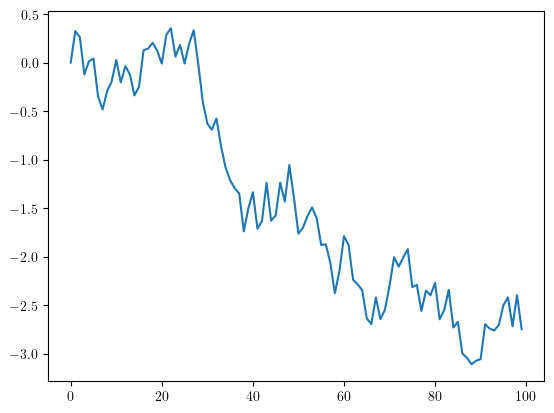

In [213]:
t = jnp.arange(p.nMax)
plt.plot(t, ag.thetFull[:-1])

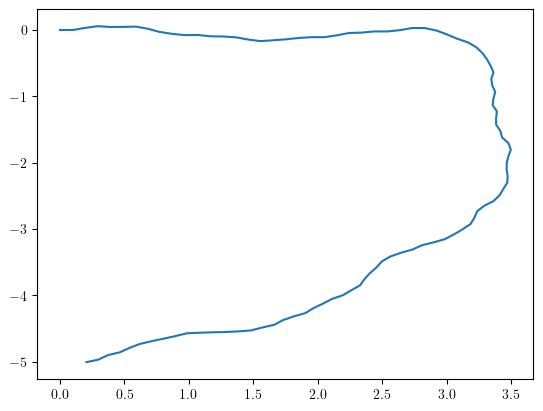

In [214]:
plt.plot(ag.rxFull, ag.ryFull)

`jit` practise with `class` as input

In [90]:
#@title Imports & Utils
# Imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node

from functools import partial
from typing import NamedTuple, Any

In [71]:
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nMax = 100
        self.dr = 0.25

class agent():
    def __init__(self) -> None:
        super().__init__()
        self.rx = 0.
        self.ry = 0.
        self.thet = 0.
        self.key = random.PRNGKey(30)
        self.subkey = self.key
    
    # @partial(jit, static_argnums=(0,))
    @jit
    def stepFwd(self, dr) -> None:
        self.key, self.subkey = random.split(self.key)
        self.rx += dr*jnp.cos(self.thet)
        self.ry += dr*jnp.sin(self.thet)
        self.thet += random.uniform(self.subkey, minval=-jnp.pi/8, maxval=jnp.pi/8)
        return jnp.array([self.rx, self.ry, self.thet])

In [72]:
p = params()
agt = agent()
agt.stepFwd(p.dr)

TypeError: Argument '<__main__.agent object at 0x7febd93372e0>' of type <class '__main__.agent'> is not a valid JAX type.

In [51]:
rxFull = agt.rx
ryFull = agt.ry
thetFull = agt.thet
# for ind in jnp.arange(p.nMax):
for ind in jnp.arange(10):
    tmp = np.array(agt.stepFwd(p.dr))
    print(tmp[0], tmp[1], tmp[2])
    ind += 1

0.49556988 0.046855383 0.22925964
0.73902863 0.10366953 0.3255304
0.9758989 0.18362238 0.2002446
1.2209034 0.23334964 -0.13899463
1.4684924 0.19871277 0.19456097
1.7137755 0.24704672 -0.017244667
1.9637383 0.24273577 -0.12567812
2.2117665 0.21139888 0.13097379
2.4596252 0.2440488 0.047201157
2.7093468 0.2558447 0.3561912


# Example code with `jit` support for simple dynamics

In [53]:
import jax.numpy as jnp
from jax import jit
from collections import namedtuple

World = namedtuple("World", ["p", "v"])

@jit
def step(world, dt):
  a = -9.8
  new_v = world.v + a * dt
  new_p = world.p + new_v * dt
  return World(new_p, new_v)

world = World(jnp.array([0, 0]), jnp.array([1, 1]))

for i in range(1000):
    world = step(world, 0.01)
    print(world.p)

[0.00902 0.00902]
[0.01706 0.01706]
[0.02412 0.02412]
[0.0302 0.0302]
[0.0353 0.0353]
[0.03942 0.03942]
[0.04256 0.04256]
[0.04472001 0.04472001]
[0.04590001 0.04590001]
[0.04610001 0.04610001]
[0.04532001 0.04532001]
[0.04356001 0.04356001]
[0.04082001 0.04082001]
[0.03710001 0.03710001]
[0.03240001 0.03240001]
[0.02672001 0.02672001]
[0.02006001 0.02006001]
[0.01242002 0.01242002]
[0.00380002 0.00380002]
[-0.00579998 -0.00579998]
[-0.01637998 -0.01637998]
[-0.02793998 -0.02793998]
[-0.04047998 -0.04047998]
[-0.05399998 -0.05399998]
[-0.06849998 -0.06849998]
[-0.08397998 -0.08397998]
[-0.10043998 -0.10043998]
[-0.11787999 -0.11787999]
[-0.13629998 -0.13629998]
[-0.15569998 -0.15569998]
[-0.17607999 -0.17607999]
[-0.19744 -0.19744]
[-0.21978 -0.21978]
[-0.2431 -0.2431]
[-0.2674 -0.2674]
[-0.29268 -0.29268]
[-0.31894 -0.31894]
[-0.34618002 -0.34618002]
[-0.37440002 -0.37440002]
[-0.40360004 -0.40360004]
[-0.43378004 -0.43378004]
[-0.46494004 -0.46494004]
[-0.49708006 -0.49708006]
[-0.53

# `jit` with random number generator

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node
import time

from functools import partial
from typing import NamedTuple, Any

In [36]:
class agentJit():
    def __init__(self, rx, ry, thet, rng):
        super().__init__()
        self.rx = rx
        self.ry = ry
        self.thet = thet
        self.rng = rng
    
    @jit
    def stepFwd(self, dr) -> None:
        new_rx = self.rx + dr*jnp.cos(self.thet)
        new_ry = self.ry + dr*jnp.sin(self.thet)
        drng = random.split(self.rng)[0]
        new_thet = self.thet + random.uniform(drng, minval=-jnp.pi/8, maxval=jnp.pi/8)
        return agentJit(new_rx, new_ry, new_thet, drng)

In [37]:
register_pytree_node(agentJit,
                     lambda x: ((x.rx, x.ry, x.thet, x.rng), None),
                     lambda _, tup: agentJit(tup[0], tup[1], tup[2], tup[3]))

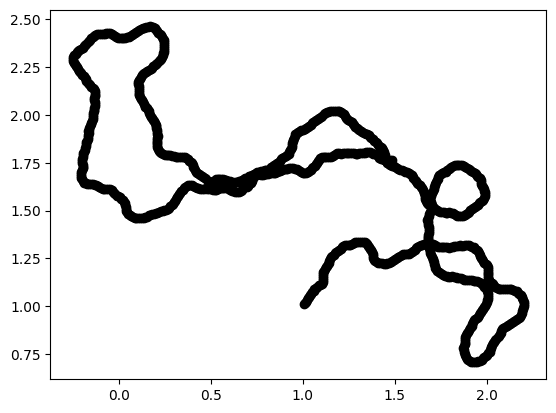

--- 0.9220232963562012 seconds ---


In [38]:
rng = random.PRNGKey(1)
aJ = agentJit(1, 1, 1, rng)
start_time = time.time()
for i in range(1000):
    aJ = aJ.stepFwd(0.01)
    plt.plot(aJ.rx, aJ.ry, 'ko')
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))